# Age Prediction based on Knee MRIs

This notebook trains a CNN to predict the age of a person based on their knee MRI. It first applies a segmentation on the bone to reduce the complexity of the problem and then continues to run a regression on the age.

## 1 Imports

In [1]:
import numpy as np
import dask.array as da
from ipywidgets import FloatProgress
from IPython.display import display
from utils import *
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob

Using TensorFlow backend.


## 2 Data Preprocessing

Load the data while applying cropping and resizing

In [2]:
#x_jop,y_jop = load_data_age('data/Jopp_Study/MHD/*.mhd',crop=(128,128,256),size=(224,224),smart_crop=True,bias=True)
#x_epi,y_epi = load_data_age('data/Epi_Study/MHD/*.mhd',crop=(120,120,560),size=(224,224),smart_crop=False,bias=True)

In [3]:
#np.savez('data/data_age', x_epi=x_epi, y_epi=y_epi, x_jop=x_jop, y_jop=y_jop)

In [4]:
x_jop = np.load('data/data_age.npz')['x_jop']
y_jop = np.load('data/data_age.npz')['y_jop']
x_epi = np.load('data/data_age.npz')['x_epi']
y_epi = np.load('data/data_age.npz')['y_epi']

The first and last slices on the z-axis show no bone matter and are therefor left empty after the segmentation is applied. I remove them here to get them out the way and also bring both data sources to the same z-axis resolution of 18 slices.

Note: The segmentation network is trained on all slices.

In [5]:
x_jop = x_jop[:, 4:-2]
x_epi = x_epi[:, 12:-11]

Create Train, Validation and Test set and convert data to 2D. 

- 2124 (118x18) samples in the training set
- 234 (13x18) samples in the validation set
- 252 (14x18) samples in the test set

In [6]:
for i in range(len(x_jop)):
    x_jop[i] = (x_jop[i] - x_jop[i].mean()) / x_jop[i].std()
for i in range(len(x_epi)):
    x_epi[i] = (x_epi[i] - x_epi[i].mean()) / x_epi[i].std()

In [7]:
x_tr_raw = np.concatenate((to_2d(x_epi[:54]), to_2d(x_jop[:64])))
y_tr = np.concatenate((lengthen(y_epi[:54], 18), lengthen(y_jop[:64], 18)))
x_va_raw = np.concatenate((to_2d(x_epi[54:59]), to_2d(x_jop[64:72])))
y_va = np.concatenate((lengthen(y_epi[54:59], 18), lengthen(y_jop[64:72], 18)))
x_te_raw = np.concatenate((to_2d(x_epi[59:]), to_2d(x_jop[72:])))
y_te = np.concatenate((lengthen(y_epi[59:], 18), lengthen(y_jop[72:], 18)))

In [8]:
y_tr_cls = to_classes(y_tr, 14, 21)
y_va_cls = to_classes(y_va, 14, 21)
y_te_cls = to_classes(y_te, 14, 21)

Load the pretrained segmentation model and predict maps for the entire data

In [9]:
model = UNet(x_tr_raw.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.load_weights('weights/seg2d_all.h5')
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss)

In [10]:
x_tr_mask = model.predict(x_tr_raw, batch_size=16, verbose=1)
x_va_mask = model.predict(x_va_raw, batch_size=16, verbose=1)
x_te_mask = model.predict(x_te_raw, batch_size=16, verbose=1)

252/252 [==============================] - 1s     


Check a few samples of the data if everything seems right

In [11]:
x_tr_mask = erode(x_tr_mask, 7)
x_va_mask = erode(x_va_mask, 7)
x_te_mask = erode(x_te_mask, 7)

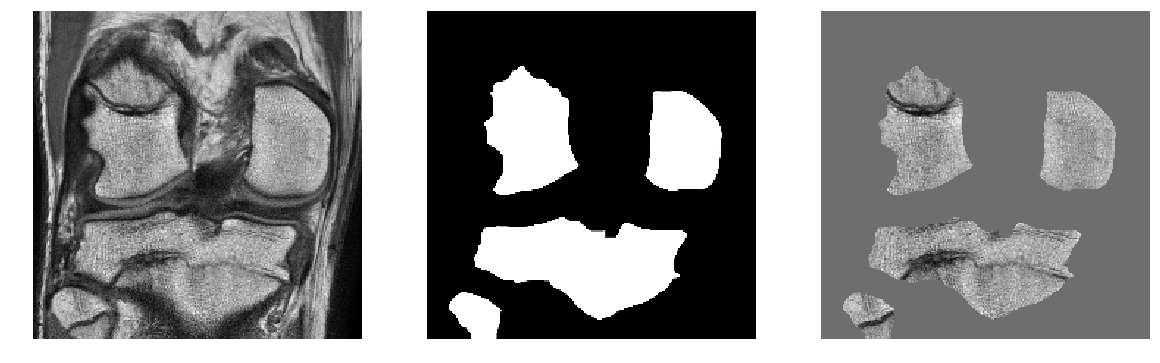

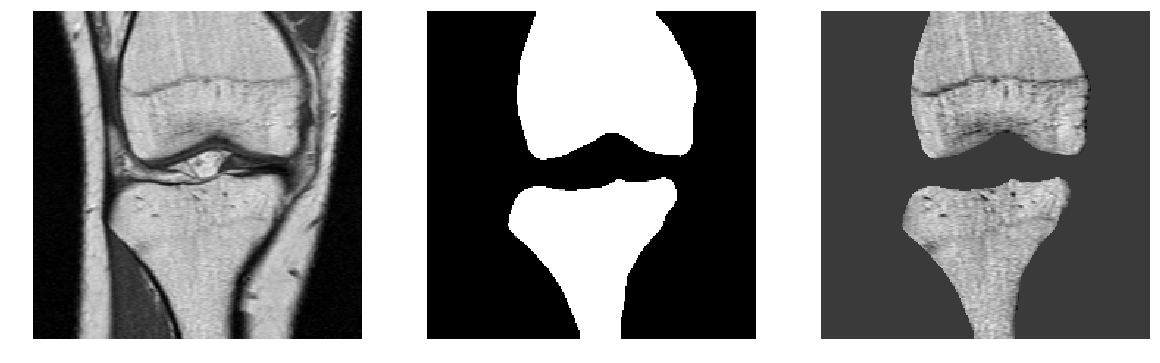

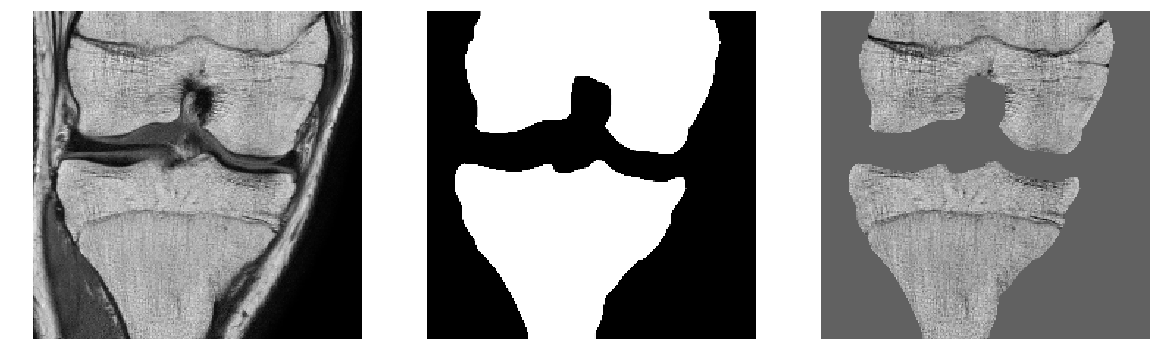

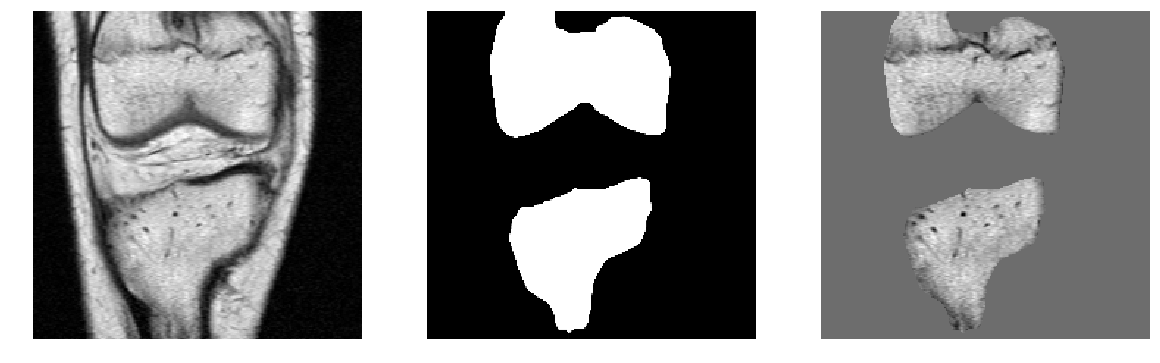

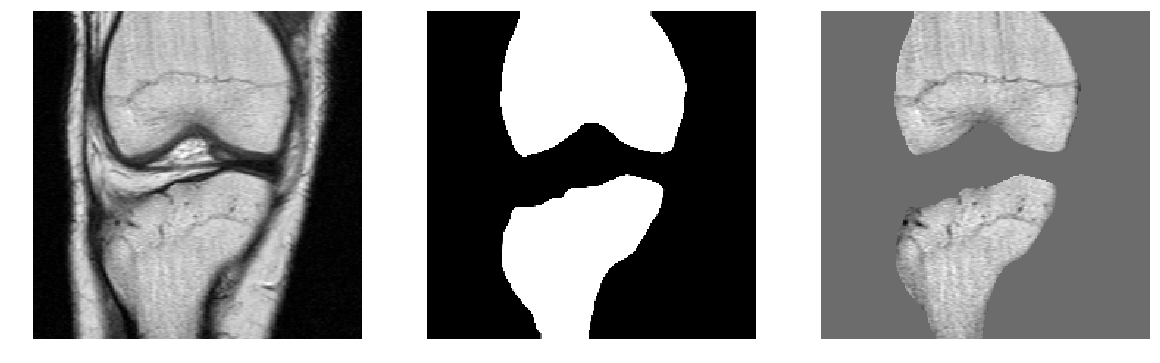

In [13]:
show_samples_2d([x_tr_raw, x_tr_mask, x_tr_raw * x_tr_mask], 5)

Let's take a look at the labels.

In [14]:
print('Oldest candidate:', round(y_tr.max(),1))
print('Youngest candidate:', round(y_tr.min(),1))
print('Age range:', round(y_tr.max()-y_tr.min(),1))
print('Average age:', round(y_tr.mean(),1))
print('Baseline:', round(abs(y_tr.mean()-y_tr).mean(),1))

('Oldest candidate:', 20.9)
('Youngest candidate:', 14.4)
('Age range:', 6.5)
('Average age:', 17.4)
('Baseline:', 1.2)


In [15]:
x_tr = x_tr_raw * x_tr_mask
x_va = x_va_raw * x_va_mask
x_te = x_te_raw * x_te_mask

Augment the training data using horizontal flips and horizontal shift at 20px. This will virtually increase the training data by a factor of 6.

In [16]:
y_te.mean()

17.541666666666668

In [17]:
x_tr, y_tr_cls = augment(x_tr, y_tr_cls, h_flip=True, edge_mode='edge')

In [18]:
y_tr = lengthen(y_tr, 2)

Let's look at the samples one more time with the segmentation mask applied.

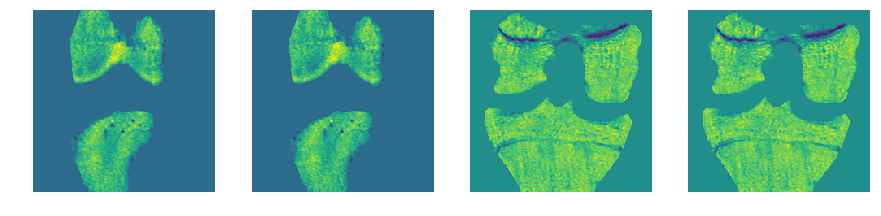

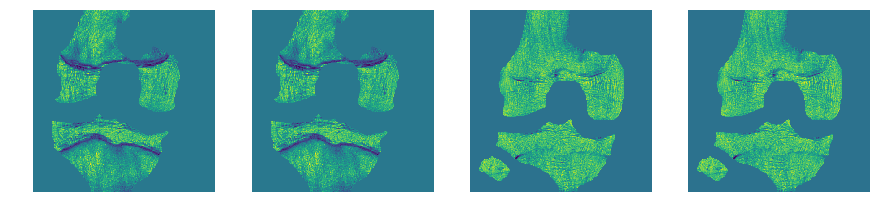

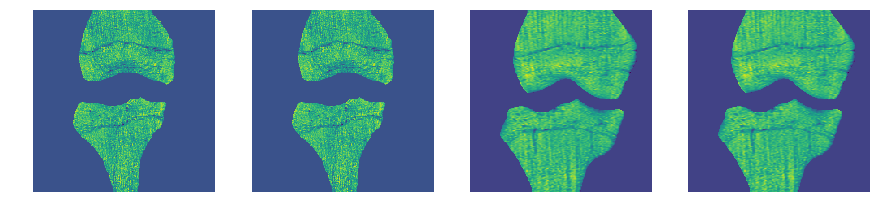

In [17]:
show_samples(x_tr, x_tr, 5)

In [18]:
print(x_tr.shape, y_tr_cls.shape)

((2124, 224, 224, 1), (2124, 7))


## 3 Training

The segmentation model from above uses a encoder-decoder architecture, which will first reduce the spatial resolution of inputs similar to common classification networks. Then on the second half expand the resolution again to create a full segmentation map.

How about we use the first half of that architecture as a pre-trained model for the age prediction? Delete the decoding layers and append 2 new ones for the regression output.

In [46]:
model = Sequential()
model.add(Conv2D(14, 5, padding='same', activation='elu', input_shape=x_tr.shape[1:]))
model.add(Conv2D(14, 5, padding='same', activation='elu'))
model.add(MaxPooling2D())
model.add(Conv2D(14, 5, padding='same', activation='elu'))
model.add(Conv2D(14, 5, padding='same', activation='elu'))
model.add(MaxPooling2D())
model.add(Conv2D(14, 5, padding='same', activation='elu'))
model.add(Conv2D(14, 5, padding='same', activation='elu'))
model.add(MaxPooling2D())
model.add(Conv2D(14, 5, padding='same', activation='elu'))
model.add(Conv2D(14, 5, padding='same', activation='elu'))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [86]:
model = UNet(x_tr.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.load_weights('weights/seg2d_all.h5')

### Merged

In [87]:
del model.layers[-17:]
x = model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x1 = Dense(y_tr_cls.shape[-1], activation='softmax')(x)
x2 = Dense(1, activation='linear')(x)
model = Model(inputs=model.input, outputs=[x1, x2])

In [88]:
model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=0.001))
model.fit(x_tr, [y_tr_cls, y_tr], validation_data=(x_va, [y_va_cls, y_va]), epochs=3, batch_size=64)

Train on 2124 samples, validate on 234 samples
Epoch 1/3
2124/2124 [==============================] - 11s - loss: 54.5165 - dense_12_loss: 5.9824 - dense_13_loss: 48.5341 - val_loss: 9.9990 - val_dense_12_loss: 5.6086 - val_dense_13_loss: 4.3904
Epoch 2/3
2124/2124 [==============================] - 10s - loss: 6.5030 - dense_12_loss: 4.0753 - dense_13_loss: 2.4277 - val_loss: 4.1499 - val_dense_12_loss: 2.1893 - val_dense_13_loss: 1.9606
Epoch 3/3
2124/2124 [==============================] - 10s - loss: 4.0415 - dense_12_loss: 1.9929 - dense_13_loss: 2.0486 - val_loss: 3.3315 - val_dense_12_loss: 1.7585 - val_dense_13_loss: 1.5730


In [89]:
model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=0.0001), metrics=['acc', 'mae'])

es = EarlyStopping(patience=14)
mc = ModelCheckpoint('weights/age2d_duo_9m.h5', save_weights_only=False, save_best_only=True)

history = model.fit(x_tr, [y_tr_cls, y_tr], validation_data=(x_va, [y_va_cls, y_va]), epochs=100, batch_size=64, callbacks=[es, mc])

Train on 2124 samples, validate on 234 samples
Epoch 1/100
2124/2124 [==============================] - 12s - loss: 3.5281 - dense_12_loss: 1.8340 - dense_13_loss: 1.6942 - dense_12_acc: 0.2721 - dense_12_mean_absolute_error: 0.2291 - dense_13_acc: 0.0363 - dense_13_mean_absolute_error: 1.0343 - val_loss: 3.0911 - val_dense_12_loss: 1.7258 - val_dense_13_loss: 1.3653 - val_dense_12_acc: 0.2222 - val_dense_12_mean_absolute_error: 0.2308 - val_dense_13_acc: 0.0000e+00 - val_dense_13_mean_absolute_error: 0.9023
Epoch 2/100
2124/2124 [==============================] - 11s - loss: 3.3586 - dense_12_loss: 1.8365 - dense_13_loss: 1.5221 - dense_12_acc: 0.2585 - dense_12_mean_absolute_error: 0.2321 - dense_13_acc: 0.0377 - dense_13_mean_absolute_error: 0.9773 - val_loss: 3.0487 - val_dense_12_loss: 1.7289 - val_dense_13_loss: 1.3198 - val_dense_12_acc: 0.1880 - val_dense_12_mean_absolute_error: 0.2318 - val_dense_13_acc: 0.0000e+00 - val_dense_13_mean_absolute_error: 0.8675
Epoch 3/100
2124/21

2124/2124 [==============================] - 11s - loss: 2.3870 - dense_12_loss: 1.4090 - dense_13_loss: 0.9781 - dense_12_acc: 0.4054 - dense_12_mean_absolute_error: 0.2013 - dense_13_acc: 0.0377 - dense_13_mean_absolute_error: 0.7891 - val_loss: 2.1817 - val_dense_12_loss: 1.3373 - val_dense_13_loss: 0.8444 - val_dense_12_acc: 0.3333 - val_dense_12_mean_absolute_error: 0.2025 - val_dense_13_acc: 0.0000e+00 - val_dense_13_mean_absolute_error: 0.7252
Epoch 36/100
2124/2124 [==============================] - 11s - loss: 2.3651 - dense_12_loss: 1.3925 - dense_13_loss: 0.9725 - dense_12_acc: 0.4237 - dense_12_mean_absolute_error: 0.2002 - dense_13_acc: 0.0372 - dense_13_mean_absolute_error: 0.7813 - val_loss: 2.1987 - val_dense_12_loss: 1.3521 - val_dense_13_loss: 0.8466 - val_dense_12_acc: 0.3632 - val_dense_12_mean_absolute_error: 0.2016 - val_dense_13_acc: 0.0000e+00 - val_dense_13_mean_absolute_error: 0.7372
Epoch 37/100
2124/2124 [==============================] - 11s - loss: 2.3525 

2124/2124 [==============================] - 11s - loss: 1.9627 - dense_12_loss: 1.2289 - dense_13_loss: 0.7338 - dense_12_acc: 0.4727 - dense_12_mean_absolute_error: 0.1846 - dense_13_acc: 0.0466 - dense_13_mean_absolute_error: 0.6703 - val_loss: 2.0982 - val_dense_12_loss: 1.2422 - val_dense_13_loss: 0.8560 - val_dense_12_acc: 0.3803 - val_dense_12_mean_absolute_error: 0.1910 - val_dense_13_acc: 0.0000e+00 - val_dense_13_mean_absolute_error: 0.7826
Epoch 70/100
2124/2124 [==============================] - 11s - loss: 1.9416 - dense_12_loss: 1.2124 - dense_13_loss: 0.7292 - dense_12_acc: 0.4821 - dense_12_mean_absolute_error: 0.1828 - dense_13_acc: 0.0527 - dense_13_mean_absolute_error: 0.6676 - val_loss: 2.0486 - val_dense_12_loss: 1.2526 - val_dense_13_loss: 0.7960 - val_dense_12_acc: 0.4316 - val_dense_12_mean_absolute_error: 0.1914 - val_dense_13_acc: 0.0000e+00 - val_dense_13_mean_absolute_error: 0.7433
Epoch 71/100
2124/2124 [==============================] - 11s - loss: 1.9310 

### Classifier

In [77]:
del model.layers[-17:]
x = model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(y_tr_cls.shape[-1], activation='softmax')(x)
model = Model(inputs=model.input, outputs=x)

In [78]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
model.fit(x_tr, y_tr_cls, validation_data=(x_va, y_va_cls), epochs=1, batch_size=64)

Train on 2124 samples, validate on 234 samples
Epoch 1/1
2124/2124 [==============================] - 11s - loss: 1.7190 - val_loss: 1.6858


In [79]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
es = EarlyStopping(patience=14)
mc = ModelCheckpoint('weights/age2d_cls_1m.h5', save_weights_only=False, save_best_only=True)
history = model.fit(x_tr, y_tr_cls, validation_data=(x_va, y_va_cls), epochs=50, batch_size=64, callbacks=[es, mc])

Train on 2124 samples, validate on 234 samples
Epoch 1/50
2124/2124 [==============================] - 11s - loss: 1.5332 - acc: 0.3823 - val_loss: 1.4886 - val_acc: 0.2778
Epoch 2/50
2124/2124 [==============================] - 10s - loss: 1.5009 - acc: 0.3936 - val_loss: 1.4560 - val_acc: 0.2991
Epoch 3/50
2124/2124 [==============================] - 10s - loss: 1.4923 - acc: 0.3917 - val_loss: 1.4753 - val_acc: 0.2906
Epoch 4/50
2124/2124 [==============================] - 10s - loss: 1.4707 - acc: 0.3969 - val_loss: 1.4303 - val_acc: 0.2906
Epoch 5/50
2124/2124 [==============================] - 10s - loss: 1.4554 - acc: 0.3964 - val_loss: 1.4245 - val_acc: 0.2650
Epoch 6/50
2124/2124 [==============================] - 10s - loss: 1.4314 - acc: 0.4087 - val_loss: 1.3361 - val_acc: 0.3077
Epoch 7/50
2124/2124 [==============================] - 10s - loss: 1.4270 - acc: 0.4082 - val_loss: 1.3985 - val_acc: 0.2821
Epoch 8/50
2124/2124 [==============================] - 10s - loss: 1.4

KeyboardInterrupt: 

### Regressor

In [83]:
del model.layers[-17:]
x = model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)
model = Model(inputs=model.input, outputs=x)

In [84]:
model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.fit(x_tr, y_tr, validation_data=(x_va, y_va), epochs=3, batch_size=64)

Train on 2124 samples, validate on 234 samples
Epoch 1/3
2124/2124 [==============================] - 11s - loss: 28.9244 - val_loss: 3.9181
Epoch 2/3
2124/2124 [==============================] - 10s - loss: 2.7734 - val_loss: 1.4577
Epoch 3/3
2124/2124 [==============================] - 10s - loss: 1.8460 - val_loss: 1.2980


In [85]:
model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
es = EarlyStopping(patience=14)
mc = ModelCheckpoint('weights/age2d_reg_1m.h5', save_weights_only=False, save_best_only=True)
model.fit(x_tr, y_tr, validation_data=(x_va, y_va), epochs=100, batch_size=64, callbacks=[es, mc])

Train on 2124 samples, validate on 234 samples
Epoch 1/100
2124/2124 [==============================] - 12s - loss: 1.6254 - mean_absolute_error: 1.0178 - val_loss: 1.2520 - val_mean_absolute_error: 0.8865
Epoch 2/100
2124/2124 [==============================] - 10s - loss: 1.5809 - mean_absolute_error: 0.9911 - val_loss: 1.2492 - val_mean_absolute_error: 0.9027
Epoch 3/100
2124/2124 [==============================] - 10s - loss: 1.4538 - mean_absolute_error: 0.9451 - val_loss: 1.1938 - val_mean_absolute_error: 0.8989
Epoch 4/100
2124/2124 [==============================] - 10s - loss: 1.5104 - mean_absolute_error: 0.9757 - val_loss: 1.1718 - val_mean_absolute_error: 0.8855
Epoch 5/100
2124/2124 [==============================] - 10s - loss: 1.4317 - mean_absolute_error: 0.9456 - val_loss: 1.1832 - val_mean_absolute_error: 0.8999
Epoch 6/100
2124/2124 [==============================] - 10s - loss: 1.3995 - mean_absolute_error: 0.9347 - val_loss: 1.1380 - val_mean_absolute_error: 0.8501

## 4 Validation

In [19]:
model = UNet(x_tr.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
del model.layers[-17:]
x = model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)
model = Model(inputs=model.input, outputs=x)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])

In [20]:
model.load_weights('weights/age_6272_pred_newnorm.h5')

In [21]:
y_tr_pred_reg = model.predict(x_tr, verbose=1)
y_va_pred_reg = model.predict(x_va, verbose=1)

224/234 [===========================>..] - ETA: 0s

In [22]:
y_tr_pred_reg = y_tr_pred_reg.sum(axis=-1)
y_va_pred_reg = y_va_pred_reg.sum(axis=-1)

In [23]:
#print(abs(y_tr - y_tr_pred_cls).mean())
print(abs(y_tr - y_tr_pred_reg).mean())
print(abs(y_tr - y_tr_pred_reg).std())

0.712145760758
0.5822191046


In [24]:
#print(abs(y_va - y_va_pred_cls).mean())
print(abs(y_va - y_va_pred_reg).mean())
print(abs(y_va - y_va_pred_reg).std())

0.639984246333
0.483379450087


In [39]:
age_vec_pred_tr_reg = np.reshape(y_tr_pred_reg, (len(y_tr_pred_reg) // 18, 18))
age_vec_pred_va_reg = np.reshape(y_va_pred_reg, (len(y_va_pred_reg) // 18, 18))

In [40]:
age_tr = np.reshape(y_tr, (len(y_tr) // 18, 18))
age_va = np.reshape(y_va, (len(y_va) // 18, 18))

In [41]:
#prob_vec_tr_cls = abs(age_tr - age_vec_pred_tr_cls).mean(axis=0)
prob_vec_tr_reg = abs(age_tr - age_vec_pred_tr_reg).mean(axis=0)

This graph shows the mean difference for each slice going from the top to the bottom. One can clearly see that middle slices show a lower error and that blue (classifier) shows worse performance on every slice in comparison to orange (regressor)

In [42]:
#prob_vec_va_cls = abs(age_va - age_vec_pred_va_cls).mean(axis=0)
prob_vec_va_reg = abs(age_va - age_vec_pred_va_reg).mean(axis=0)

On the validation set it is definitely less stable

<Container object of 18 artists>

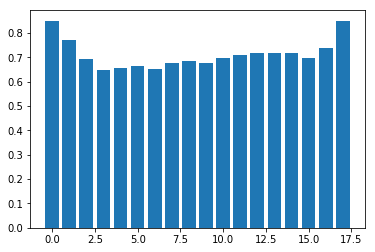

In [45]:
plt.bar(range(18), prob_vec_tr_reg)

<Container object of 18 artists>

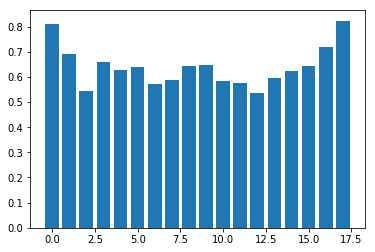

In [44]:
#plt.bar(range(18), prob_vec_va_cls)
plt.bar(range(18), prob_vec_va_reg)
#plt.show()

In [43]:
age_tr = shorten(y_tr, 18)
age_va = shorten(y_va, 18)

In [46]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
reg = ExtraTreesRegressor(max_depth=3)
#reg = LinearRegression()
reg.fit(age_vec_pred_tr_reg, age_tr)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=3,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [47]:
from sklearn.externals import joblib
reg = joblib.load('weights/ExtraTreesRegressor_1.pkl') 

In [48]:
age_pred_tr = reg.predict(age_vec_pred_tr_reg)
age_pred_va = reg.predict(age_vec_pred_va_reg)

In [49]:
print(abs(age_tr - age_pred_tr).mean())
print(abs(age_tr - age_pred_tr).std())

0.45699032254
0.347454764364


In [50]:
print(abs(age_va - age_pred_va).mean())
print(abs(age_va - age_pred_va).std())

0.560296180122
0.403735807116


### Classifier

In [21]:
model = load_model('weights/age2d_3m.h5')

y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)

y_tr_reg = np.zeros(len(y_tr_pred))
for i in range(len(y_tr_pred)):
    y_tr_reg[i] = (y_tr_pred[i]*range(14,21)).sum()

y_va_reg = np.zeros(len(y_va_pred))
for i in range(len(y_va_pred)):
    y_va_reg[i] = (y_va_pred[i]*range(14,21)).sum()
    
print('Train Mean Vec: ' + str(abs(y_tr - y_tr_reg).mean()))
print('Valid Mean Vec: ' + str(abs(y_va - y_va_reg).mean()))

num_slc = 18
age_vec_pred_tr = np.reshape(y_tr_reg, (len(y_tr_reg) // num_slc, num_slc))
age_vec_pred_va = np.reshape(y_va_reg, (len(y_va_reg) // num_slc, num_slc))
age_tr = shorten(y_tr, num_slc)
age_va = shorten(y_va, num_slc)

ValueError: operands could not be broadcast together with shapes (2124,) (4248,) 

### Regressor

In [90]:
model = load_model('weights/age2d_3m.h5')

evl = model.evaluate(x_va, y_va, verbose=0)
print('MSE: ' + str(round(evl[0],2)) + ' years')
print('MAE: ' + str(round(evl[1],2)) + ' years')

age_vec_pred_tr = model.predict(x_tr, verbose=1).sum(axis=-1)
age_vec_pred_va = model.predict(x_va, verbose=1).sum(axis=-1)

num_slc = 18 # number of slices
age_vec_pred_tr = np.reshape(age_vec_pred_tr, (len(age_vec_pred_tr) // num_slc, num_slc))
age_vec_pred_va = np.reshape(age_vec_pred_va, (len(age_vec_pred_va) // num_slc, num_slc))
age_tr = shorten(y_tr, num_slc)
age_va = shorten(y_va, num_slc)

MSE: 0.62 years
MAE: 0.66 years


In [102]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
reg = ExtraTreesRegressor(max_depth=2)
#reg = LinearRegression()
reg.fit(age_vec_pred_tr[:2124], age_tr[:2124])

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=2,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [429]:
from sklearn.externals import joblib
joblib.dump(reg, 'weights/ExtraTreesRegressor_1.pkl') 

['weights/ExtraTreesRegressor_1.pkl']

In [430]:
clf = joblib.load('weights/ExtraTreesRegressor_1.pkl') 

In [ ]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(verbosity=2, generations=3, population_size=100)
tpot.fit(age_vec_pred_tr[:2124], age_tr[:2124])

Let's look at the number of training and validation

In [104]:
age_pred_tr = reg.predict(age_vec_pred_tr)
abs(age_pred_tr - age_tr).mean()

0.57475075523629759

In [105]:
age_pred_va = reg.predict(age_vec_pred_va)
abs(age_pred_va - age_va).mean()

0.72284930492571797

## 6 Final Verification

At this point I allow myself a run on the test set to see if any of this makes sense. We have not used the test set in any way, except for normalizing it on the training data. We have no information how the pipeline above performs on the test set.

In [54]:
y_te_pred_reg = model.predict(x_te, verbose=1)
y_te_pred_reg = y_te_pred_reg.sum(axis=-1)
print(' - ')
print('Vec Mean ' + str(abs(y_te - y_te_pred_reg).mean()))
age_vec_pred_te_reg = np.reshape(y_te_pred_reg, (len(y_te_pred_reg) // 18, 18))
age_te = shorten(y_te, 18)

age_pred_te = reg.predict(age_vec_pred_te_reg)
print(' - ')
print('Mean ' + str(abs(age_te - age_pred_te).mean()))
print('Std  ' + str(abs(age_te - age_pred_te).std()))
print('Min  ' + str(abs(age_te - age_pred_te).min()))
print('Max  ' + str(abs(age_te - age_pred_te).max()))

224/252 [=========================>....] - ETA: 0s - 
Vec Mean 0.731019899328
 - 
Mean 0.484716052419
Std  0.317834441707
Min  0.0742235705471
Max  1.36835769819


### Classifier Mode

In [110]:
y_te_pred = model.predict(x_te)

y_te_reg = np.zeros(len(y_te_pred))
for i in range(len(y_te_pred)):
    y_te_reg[i] = (y_te_pred[i]*range(14,21)).sum()
    
age_vec_pred_te = np.reshape(y_te_reg, (len(y_te_reg) // num_slc, num_slc))
age_te = shorten(y_te, num_slc)

age_pred_te = reg.predict(age_vec_pred_te)

te_mae = abs(age_pred_te - age_te).mean()
print('The mean absolute error across ' + str(len(age_pred_te)) + ' samples is ' + str(round(te_mae, 3)) + ' years.')

The mean absolute error across 14 samples is 0.616 years.


### Regressor Mode

In [235]:
age_vec_pred_te.shape

(14, 18)

In [230]:
age_vec_pred_te = model.predict(x_te).sum(axis=-1)
age_vec_pred_te = np.reshape(age_vec_pred_te, (len(age_vec_pred_te) // 18, 18))
age_te = shorten(y_te, 18)
age_pred_te = reg.predict(age_vec_pred_te)

te_mae = abs(age_pred_te - age_te).mean()
print('The mean absolute error across ' + str(len(age_pred_te)) + ' samples is ' + str(round(te_mae, 3)) + ' years.')

ValueError: operands could not be broadcast together with shapes (14,18) (14,) 

## 7 Trash

In [102]:
age_vec_pred_tr_cls = np.reshape(y_tr_pred_cls, (len(y_tr_pred_cls) // 18, 18))
age_vec_pred_va_cls = np.reshape(y_va_pred_cls, (len(y_va_pred_cls) // 18, 18))

In [93]:
y_tr_pred_cls = np.zeros(len(y_tr_pred))
for i in range(len(y_tr_pred)):
    y_tr_pred_cls[i] = (y_tr_pred[i]*range(14,21)).sum()

y_va_pred_cls = np.zeros(len(y_va_pred))
for i in range(len(y_va_pred)):
    y_va_pred_cls[i] = (y_va_pred[i]*range(14,21)).sum()